# Modern Training Techniques

# Loading Libraries

In [ ]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Dataset's Iteration Performance
from tqdm import tqdm

# Time
import time

# OS
import sys
import string
import unicodedata
import requests, zipfile, io

# SciPy
from scipy.signal import convolve

# PyTorch
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import *
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Optuna
import optuna

# IDLMAM Libraries
from idlmam import moveTo, run_epoch
from idlmam import train_simple_network, set_seed, Flatten, weight_reset

# Scikit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#  IPython Display
from IPython.display import Latex
from IPython.display import display_pdf
from IPython.display import set_matplotlib_formats

/shared-libs/python3.10/py/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Visualization Set-Up

In [ ]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

### Setting Seeds

In [ ]:
torch.backends.cudnn.deterministic=True

set_seed(45)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Gradient Descent in (2) Two Parts

### Implementing Optimizers & Schedulers

Updating The Training Code

In [ ]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None,
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):

    if score_funcs == None:
        score_funcs = {}

    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )

    total_train_time = 0 
    results = {}
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )


        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")

        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()

        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

### Using The New Training Code

In [ ]:
# Training Epochs
epochs = 50
# BatcH size
B = 256

train_data = torchvision.datasets.FashionMNIST("./data",
                                               train=True,
                                               transform=transforms.ToTensor(),
                                               download=True)

test_data = torchvision.datasets.FashionMNIST("./data",
                                              train=False,
                                              transform=transforms.ToTensor(),
                                              download=True)

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Standard Image Size
D = 28*28

#Hidden Layer size
n = 128

# Channels
C = 1

# Classes Set-Up
classes = 10

fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [ ]:
# Learning Rate
eta_0 = 0.1

In [ ]:
# Loss Function
loss_func = nn.CrossEntropyLoss()

# Training Model
fc_results = train_network(fc_model,
                           loss_func,
                           train_loader,
                           test_loader=test_loader,
                           epochs=epochs,
                           optimizer=torch.optim.SGD(fc_model.parameters(),lr=eta_0),
                           score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:12<10:00, 12.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:23<09:19, 11.65s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:34<08:57, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:45<08:43, 11.39s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:57<08:29, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:08<08:16, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:19<08:04, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:30<07:52, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:41<07:39, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:53<07:27, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:04<07:16, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:15<07:06, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:26<06:56, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:38<06:44, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:49<06:33, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:00<06:22, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:11<06:11, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:23<05:59, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:34<05:49, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:45<05:37, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:56<05:25, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:08<05:14, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:19<05:02, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:30<04:52, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:41<04:41, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:53<04:29, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:04<04:18, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:15<04:07, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:26<03:55, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:37<03:44, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:49<03:33, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:00<03:21, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:11<03:10, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:22<03:00, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:34<02:49, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:45<02:38, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:56<02:26, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:08<02:15, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:19<02:03, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:30<01:52, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:41<01:41, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:53<01:30, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:04<01:19, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:15<01:07, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:26<00:56, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:38<00:45, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:49<00:33, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:00<00:22, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:12<00:11, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:23<00:00, 11.27s/it]


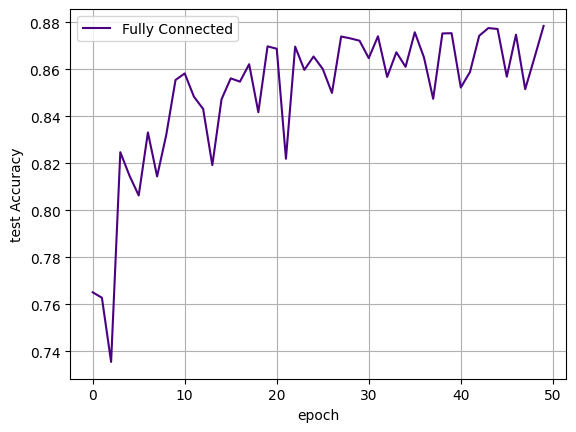

In [ ]:
sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results,
             label='Fully Connected',
             color='indigo')

plt.grid(True)
plt.show()

## Learning Rate Schedules

### Exponential Decay: Smoothing Erratic Training

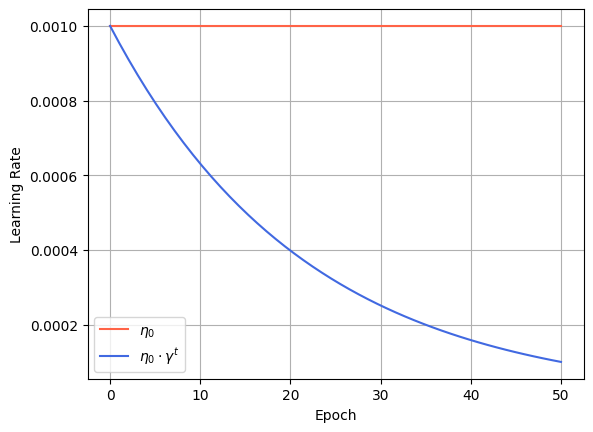

In [ ]:
# Total Epochs
T=50
# Value Generator
epochs_input = np.linspace(0, 50, num=50)
eta_init = 0.001
eta_min = 0.0001
gamma = np.power(eta_min/eta_init,1./T)

effective_learning_rate = eta_init*np.power(gamma, epochs_input)

sns.lineplot(x=epochs_input,
             y=eta_init,
             color='tomato',
             label="$\eta_0$")

ax = sns.lineplot(x=epochs_input,
                  y=effective_learning_rate,
                  color='royalblue',
                  label="$\eta_0 \cdot \gamma^t$")

ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(True)
plt.show()

resetting model weights as follows:

In [ ]:
fc_model.apply(weight_reset)

# Desired Minimal Final Learning Rate
eta_min = 0.0001

# Gamma Exposure: Computiong Decay rate base on Minimal Learning
gamma_expo = (eta_min/eta_0)**(1/epochs)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma_expo)

fc_results_expolr = train_network(fc_model,
                                  loss_func,
                                  train_loader,
                                  test_loader=test_loader,
                                  epochs=epochs,
                                  optimizer=optimizer,
                                  lr_schedule=scheduler,
                                  score_funcs={'Accuracy': accuracy_score},
                                  device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:13, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<09:00, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:33<08:50, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:45<08:41, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:56<08:27, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:07<08:16, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:18<08:03, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:30<07:52, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:41<07:41, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:52<07:28, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:03<07:19, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:15<07:08, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:26<06:57, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:37<06:45, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:49<06:34, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:00<06:23, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:11<06:09, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:22<06:00, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:34<05:49, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:45<05:38, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:56<05:27, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:07<05:15, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:19<05:05, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:30<04:54, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:41<04:42, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:53<04:32, 11.35s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:04<04:20, 11.35s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:16<04:09, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:27<03:58, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:38<03:46, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:49<03:34, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:01<03:23, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:12<03:11, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:23<02:59, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:34<02:48, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:46<02:37, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:57<02:26, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:08<02:15, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:19<02:03, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:31<01:52, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:42<01:41, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:53<01:29, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:04<01:18, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:15<01:07, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:27<00:56, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:38<00:45, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:49<00:33, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:01<00:22, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:12<00:11, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:23<00:00, 11.27s/it]


### Step Drop Adjustment: Better Smoothing

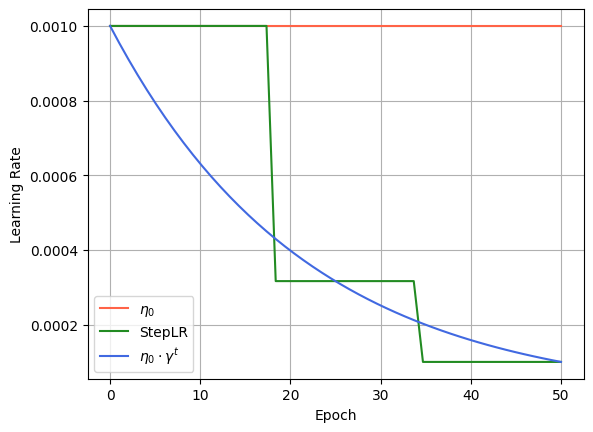

In [ ]:
#
sns.lineplot(x=epochs_input,
             y=eta_init,
             color='tomato',
             label="$\eta_0$")

sns.lineplot(x=epochs_input,
             y=[eta_init]*18+[eta_init/3.16]*16+[eta_init/10]*16,
             color='forestgreen',
             label="StepLR")

ax = sns.lineplot(x=epochs_input,
                  y=effective_learning_rate,
                  color='royalblue',
                  label="$\eta_0 \cdot \gamma^t$")
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')

plt.grid(True)
plt.show()

Training on drop adjustment:

In [ ]:
fc_model.apply(weight_reset)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs//4, gamma=0.3)

fc_results_steplr = train_network(fc_model,
                                  loss_func,
                                  train_loader,
                                  test_loader=test_loader,
                                  epochs=epochs,
                                  optimizer=optimizer,
                                  lr_schedule=scheduler,
                                  score_funcs={'Accuracy': accuracy_score},
                                  device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:10, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<08:56, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:33<08:45, 11.19s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:44<08:35, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:56<08:25, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:07<08:14, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:18<08:02, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:29<07:51, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:40<07:40, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:52<07:28, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:03<07:14, 11.14s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:14<07:03, 11.15s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:25<06:52, 11.16s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:36<06:42, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:48<06:32, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [02:59<06:22, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:10<06:10, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:21<05:57, 11.16s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:32<05:46, 11.18s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:44<05:36, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:55<05:26, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:06<05:14, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:17<05:02, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:28<04:50, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:40<04:39, 11.18s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:51<04:29, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:02<04:17, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:13<04:06, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:24<03:55, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:36<03:44, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:47<03:33, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [05:58<03:21, 11.19s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:09<03:10, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:21<02:59, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:32<02:48, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:43<02:37, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:54<02:26, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:06<02:14, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:17<02:03, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:28<01:52, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:39<01:41, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:51<01:29, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:02<01:18, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:13<01:07, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:24<00:56, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:35<00:44, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:47<00:33, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [08:58<00:22, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:09<00:11, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:21<00:00, 11.22s/it]


### Cosine Anneling: Greater Accuracy but Less Stability

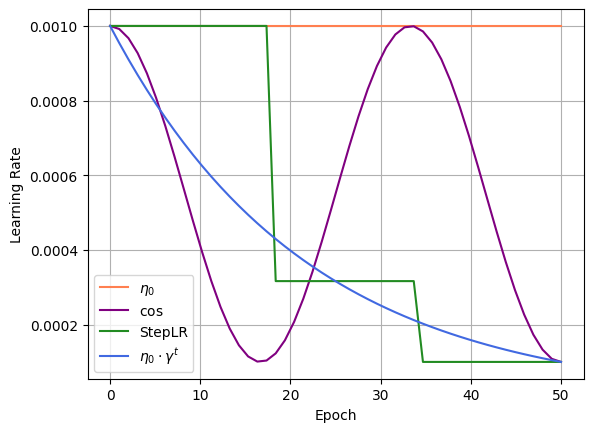

In [ ]:
cos_lr = eta_min + 0.5*(eta_init-eta_min)*(1+np.cos(epochs_input/(T/3.0)*np.pi))

sns.lineplot(x=epochs_input,
             y=eta_init,
             color='coral',
             label="$\eta_0$")

sns.lineplot(x=epochs_input,
             y=cos_lr,
             color='purple',
             label="$\cos$")

sns.lineplot(x=epochs_input,
             y=[eta_init]*18+[eta_init/3.16]*16+[eta_init/10]*16,
             color='forestgreen',
             label="StepLR")

ax = sns.lineplot(x=epochs_input,
                  y=effective_learning_rate,
                  color='royalblue',
                  label="$\eta_0 \cdot \gamma^t$")

ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')

plt.grid(True)
plt.show()

In [ ]:
fc_model.apply(weight_reset)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3, eta_min=0.0001)

fc_results_coslr = train_network(fc_model,
                                 loss_func,
                                 train_loader,
                                 test_loader=test_loader,
                                 epochs=epochs,
                                 optimizer=optimizer,
                                 lr_schedule=scheduler,
                                 score_funcs={'Accuracy': accuracy_score},
                                 device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:02, 11.07s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<08:55, 11.16s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:33<08:47, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:44<08:38, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:56<08:26, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:07<08:15, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:18<08:03, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:29<07:53, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:41<07:39, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:52<07:29, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:03<07:17, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:14<07:07, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:26<06:57, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:37<06:46, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:48<06:32, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [02:59<06:22, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:11<06:11, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:22<06:00, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:33<05:49, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:44<05:36, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:55<05:24, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:07<05:14, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:18<05:03, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:29<04:52, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:40<04:40, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:52<04:29, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:03<04:17, 11.19s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:14<04:07, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:25<03:55, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:36<03:44, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:48<03:32, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [05:59<03:21, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:10<03:09, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:21<02:58, 11.18s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:32<02:48, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:44<02:37, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:55<02:26, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:06<02:14, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:17<02:03, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:29<01:52, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:40<01:41, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:51<01:30, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:02<01:18, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:14<01:07, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:25<00:56, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:36<00:44, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:47<00:33, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [08:58<00:22, 11.16s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:10<00:11, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:21<00:00, 11.23s/it]


### Validation Plateau: Data-Based Adjustments

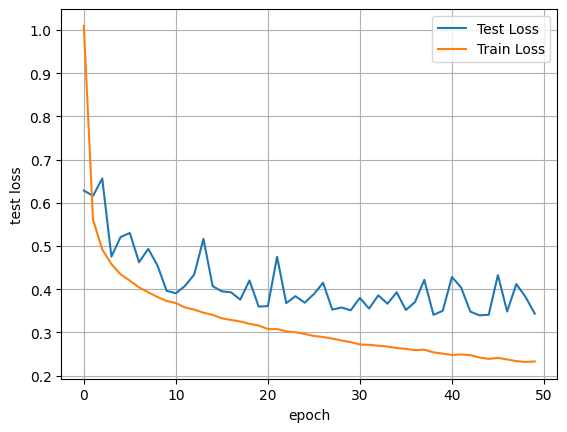

In [ ]:
sns.lineplot(x='epoch',
             y='test loss',
             data=fc_results,
             label='Test Loss')

sns.lineplot(x='epoch',
             y='train loss',
             data=fc_results,
             label='Train Loss')

plt.grid(True)
plt.show()

Splitting Data on Plateay Judgement as follows:

In [ ]:
# Weight's Reset
fc_model.apply(weight_reset) 

# Training & Validation Sets
train_sub_set, val_sub_set = torch.utils.data.random_split(train_data, [int(len(train_data)*0.8), int(len(train_data)*0.2)])

# Model's Loader
train_sub_loader = DataLoader(train_sub_set, batch_size=B, shuffle=True)
val_sub_loader = DataLoader(val_sub_set, batch_size=B)


optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10)#Set up our plateau schedule using gamma=0.2

# Training Procedure
fc_results_plateau = train_network(fc_model,
                                   loss_func,
                                   train_loader,
                                   val_loader=val_sub_loader,
                                   test_loader=test_loader,
                                   epochs=epochs, optimizer=optimizer,
                                   lr_schedule=scheduler,
                                   score_funcs={'Accuracy': accuracy_score},
                                   device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:13<10:40, 13.07s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:26<10:27, 13.07s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:39<10:13, 13.06s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:52<10:02, 13.10s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [01:05<09:48, 13.07s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:18<09:33, 13.02s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:31<09:19, 13.01s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:44<09:06, 13.02s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:57<08:54, 13.03s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [02:10<08:43, 13.10s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:23<08:31, 13.11s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:36<08:16, 13.08s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:49<08:02, 13.03s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [03:02<07:50, 13.07s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [03:15<07:37, 13.07s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:29<07:25, 13.09s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:42<07:13, 13.13s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:55<07:00, 13.14s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [04:08<06:46, 13.13s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [04:21<06:34, 13.16s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [04:34<06:21, 13.16s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:48<06:08, 13.15s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [05:01<05:54, 13.14s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [05:14<05:41, 13.12s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [05:27<05:27, 13.10s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [05:40<05:12, 13.02s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:53<05:00, 13.06s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [06:06<04:47, 13.09s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [06:19<04:35, 13.10s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [06:32<04:22, 13.10s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [06:45<04:09, 13.12s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:58<03:56, 13.13s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [07:12<03:42, 13.11s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [07:25<03:30, 13.14s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [07:38<03:17, 13.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [07:51<03:03, 13.12s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [08:04<02:50, 13.11s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [08:17<02:37, 13.11s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [08:30<02:24, 13.11s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [08:43<02:11, 13.12s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [08:57<01:57, 13.10s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [09:10<01:44, 13.08s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [09:23<01:31, 13.08s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [09:36<01:18, 13.05s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [09:49<01:05, 13.00s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [10:02<00:52, 13.04s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [10:15<00:39, 13.05s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [10:28<00:26, 13.01s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [10:41<00:13, 13.06s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [10:54<00:00, 13.09s/it]


Comparing The Schedules:

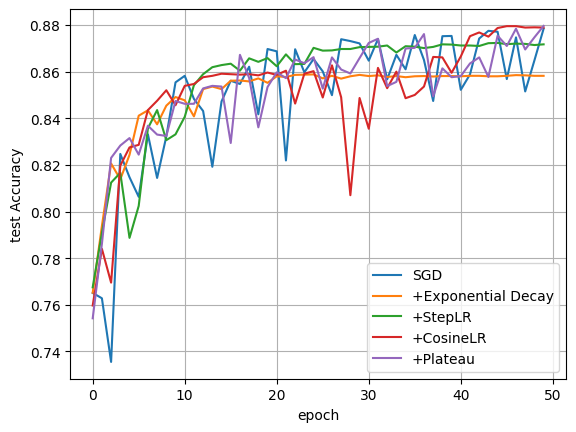

In [ ]:
sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results,
             label='SGD')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_expolr,
             label='+Exponential Decay')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_steplr,
             label='+StepLR')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_coslr,
             label='+CosineLR')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_plateau,
             label='+Plateau')

plt.grid(True)
plt.show()

## Making Better Use of Gradients

### Nesterov Momentum

In [ ]:
fc_model.apply(weight_reset)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=False)

fc_results_momentum = train_network(fc_model,
                                    loss_func, train_loader,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs={'Accuracy': accuracy_score},
                                    device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:18, 11.40s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<08:57, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:33<08:47, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:45<08:37, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:56<08:25, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:07<08:11, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:18<08:02, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:29<07:52, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:41<07:41, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:52<07:26, 11.17s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:03<07:16, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:14<07:07, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:26<06:56, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:37<06:44, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:49<06:38, 11.40s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:00<06:28, 11.43s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:11<06:15, 11.38s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:23<06:04, 11.39s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:34<05:52, 11.38s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:45<05:40, 11.36s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:57<05:27, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:08<05:16, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:19<05:04, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:30<04:53, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:42<04:41, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:53<04:31, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:04<04:19, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:16<04:09, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:27<03:56, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:38<03:45, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:49<03:34, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:01<03:22, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:12<03:10, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:23<03:00, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:34<02:49, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:45<02:37, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:57<02:26, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:08<02:15, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:19<02:04, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:31<01:52, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:42<01:41, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:53<01:30, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:04<01:18, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:16<01:07, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:27<00:56, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:38<00:45, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:49<00:33, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:01<00:22, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:12<00:11, 11.35s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:24<00:00, 11.28s/it]


In [ ]:
fc_model.apply(weight_reset)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True)

fc_results_nestrov = train_network(fc_model,
                                   loss_func,
                                   train_loader,
                                   test_loader=test_loader,
                                   epochs=epochs,
                                   optimizer=optimizer,
                                   score_funcs={'Accuracy': accuracy_score},
                                   device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:06, 11.15s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<09:03, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:33<08:51, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:44<08:35, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:56<08:27, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:07<08:16, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:18<08:06, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:30<07:52, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:41<07:42, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:52<07:31, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:04<07:19, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:15<07:10, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:26<06:58, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:38<06:48, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:49<06:34, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:00<06:23, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:11<06:12, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:23<06:00, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:34<05:49, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:45<05:39, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:56<05:26, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:08<05:15, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:19<05:05, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:31<04:54, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:42<04:42, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:53<04:31, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:04<04:19, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:16<04:07, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:27<03:56, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:38<03:46, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:49<03:33, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:01<03:23, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:12<03:12, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:24<03:01, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:35<02:49, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:46<02:38, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:58<02:27, 11.35s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:09<02:15, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:20<02:04, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:31<01:53, 11.34s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:43<01:41, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:54<01:30, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:05<01:19, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:17<01:07, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:28<00:56, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:39<00:45, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:50<00:33, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:02<00:22, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:13<00:11, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:24<00:00, 11.30s/it]


### Comparing SGD with Momentums

<AxesSubplot: xlabel='epoch', ylabel='test Accuracy'>

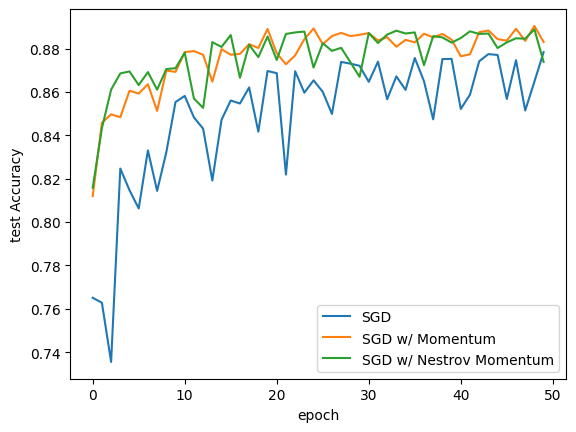

In [ ]:
sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results,
             label='SGD')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_momentum,
             label='SGD w/ Momentum')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_nestrov,
             label='SGD w/ Nestrov Momentum')

### ADAM: Adding Variance to Momentum

In [ ]:
fc_model.apply(weight_reset)

optimizer = torch.optim.AdamW(fc_model.parameters())

fc_results_adam = train_network(fc_model,
                                loss_func, train_loader,
                                test_loader=test_loader,
                                epochs=epochs,
                                optimizer=optimizer,
                                score_funcs={'Accuracy': accuracy_score},
                                device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:20, 11.43s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:23<09:14, 11.55s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:34<09:03, 11.56s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:45<08:47, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:57<08:37, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:09<08:27, 11.54s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:20<08:13, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:32<08:03, 11.52s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:43<07:51, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:54<07:37, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:06<07:27, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:17<07:17, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:29<07:03, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:40<06:53, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:52<06:42, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:03<06:28, 11.43s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:15<06:17, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:26<06:06, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:37<05:53, 11.40s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:49<05:43, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [04:00<05:32, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:12<05:19, 11.39s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:23<05:09, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:35<04:57, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:46<04:45, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:58<04:36, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:09<04:24, 11.52s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:21<04:11, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:32<04:01, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:44<03:50, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:55<03:38, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:07<03:27, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:19<03:16, 11.56s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:30<03:04, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:41<02:52, 11.53s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:53<02:41, 11.57s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [07:04<02:29, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:16<02:18, 11.52s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:28<02:06, 11.54s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:39<01:54, 11.49s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:51<01:43, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [08:02<01:32, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:13<01:20, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:25<01:09, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:36<00:57, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:48<00:45, 11.41s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:59<00:34, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:11<00:22, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:22<00:11, 11.42s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:34<00:00, 11.48s/it]


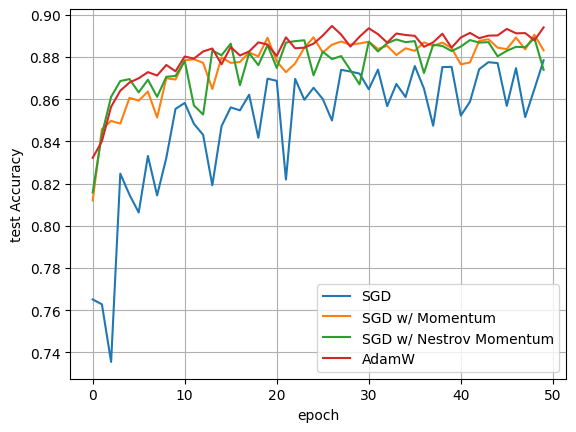

In [ ]:
sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results,
             label='SGD')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_momentum,
             label='SGD w/ Momentum')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_nestrov,
             label='SGD w/ Nestrov Momentum')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_adam,
             label='AdamW')

plt.grid(True)
plt.show()

In [ ]:
#Adam with Cosine Annealing
fc_model.apply(weight_reset)

optimizer = torch.optim.AdamW(fc_model.parameters())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3)

fc_results_adam_coslr = train_network(fc_model,
                                      loss_func,
                                      train_loader,
                                      test_loader=test_loader,
                                      epochs=epochs,
                                      optimizer=optimizer,
                                      lr_schedule=scheduler,
                                      score_funcs={'Accuracy': accuracy_score},
                                      device=device)

#SGD+Nestrov with Cosine Annealing 
fc_model.apply(weight_reset)

optimizer = torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3)

fc_results_nestrov_coslr = train_network(fc_model,
                                         loss_func, train_loader,
                                         test_loader=test_loader,
                                         epochs=epochs,
                                         optimizer=optimizer,
                                         lr_schedule=scheduler,
                                         score_funcs={'Accuracy': accuracy_score},
                                         device=device)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:30, 11.64s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<09:10, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:34<09:01, 11.52s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:46<08:49, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:57<08:36, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:09<08:25, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:20<08:15, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:31<08:00, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:43<07:50, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:54<07:38, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:06<07:25, 11.41s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:17<07:15, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:29<07:04, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:40<06:51, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:52<06:42, 11.49s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:03<06:31, 11.52s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:15<06:17, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:26<06:06, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:38<05:55, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:49<05:43, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [04:01<05:33, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:12<05:22, 11.51s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:23<05:09, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:35<04:58, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:46<04:45, 11.41s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:58<04:35, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:10<04:25, 11.54s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:21<04:11, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:32<04:01, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:44<03:49, 11.50s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:55<03:37, 11.42s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:07<03:26, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:18<03:15, 11.49s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:29<03:02, 11.41s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:41<02:51, 11.46s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:53<02:40, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [07:04<02:29, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:15<02:17, 11.48s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:27<02:05, 11.42s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:38<01:54, 11.44s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:50<01:43, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [08:01<01:31, 11.39s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:13<01:20, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:24<01:08, 11.49s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:36<00:57, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:47<00:45, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:59<00:34, 11.53s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:10<00:22, 11.45s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:21<00:11, 11.47s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   2%|▏         | 1/50 [00:11<09:06, 11.15s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   4%|▍         | 2/50 [00:22<08:57, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   6%|▌         | 3/50 [00:33<08:43, 11.15s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   8%|▊         | 4/50 [00:44<08:36, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  10%|█         | 5/50 [00:56<08:27, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  12%|█▏        | 6/50 [01:07<08:13, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  14%|█▍        | 7/50 [01:18<08:04, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  16%|█▌        | 8/50 [01:30<07:55, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 9/50 [01:41<07:42, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  20%|██        | 10/50 [01:52<07:32, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  22%|██▏       | 11/50 [02:04<07:21, 11.31s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  24%|██▍       | 12/50 [02:15<07:06, 11.22s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  26%|██▌       | 13/50 [02:26<06:56, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  28%|██▊       | 14/50 [02:37<06:46, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  30%|███       | 15/50 [02:48<06:33, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  32%|███▏      | 16/50 [03:00<06:22, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  34%|███▍      | 17/50 [03:11<06:10, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  36%|███▌      | 18/50 [03:22<05:59, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 19/50 [03:33<05:50, 11.29s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  40%|████      | 20/50 [03:44<05:36, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  42%|████▏     | 21/50 [03:56<05:26, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  44%|████▍     | 22/50 [04:07<05:16, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  46%|████▌     | 23/50 [04:18<05:03, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  48%|████▊     | 24/50 [04:30<04:53, 11.27s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  50%|█████     | 25/50 [04:41<04:42, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  52%|█████▏    | 26/50 [04:52<04:29, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  54%|█████▍    | 27/50 [05:04<04:19, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  56%|█████▌    | 28/50 [05:15<04:07, 11.23s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  58%|█████▊    | 29/50 [05:26<03:56, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  60%|██████    | 30/50 [05:38<03:47, 11.37s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  62%|██████▏   | 31/50 [05:49<03:35, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  64%|██████▍   | 32/50 [06:00<03:24, 11.37s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  66%|██████▌   | 33/50 [06:12<03:13, 11.39s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  68%|██████▊   | 34/50 [06:23<03:01, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  70%|███████   | 35/50 [06:34<02:50, 11.36s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  72%|███████▏  | 36/50 [06:45<02:37, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  74%|███████▍  | 37/50 [06:57<02:26, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  76%|███████▌  | 38/50 [07:08<02:15, 11.33s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  78%|███████▊  | 39/50 [07:19<02:03, 11.24s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  80%|████████  | 40/50 [07:31<01:52, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  82%|████████▏ | 41/50 [07:42<01:41, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  84%|████████▍ | 42/50 [07:53<01:30, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  86%|████████▌ | 43/50 [08:05<01:19, 11.32s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  88%|████████▊ | 44/50 [08:16<01:07, 11.25s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 45/50 [08:27<00:56, 11.28s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  92%|█████████▏| 46/50 [08:38<00:45, 11.30s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  94%|█████████▍| 47/50 [08:49<00:33, 11.20s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  96%|█████████▌| 48/50 [09:01<00:22, 11.26s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:  98%|█████████▊| 49/50 [09:12<00:11, 11.21s/it]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [09:23<00:00, 11.27s/it]


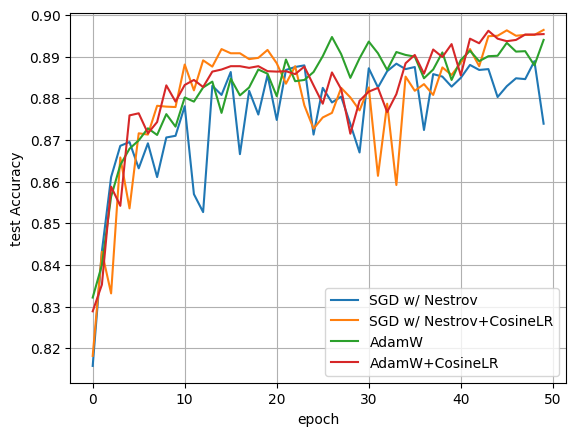

In [ ]:
sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_nestrov,
             label='SGD w/ Nestrov')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_nestrov_coslr,
             label='SGD w/ Nestrov+CosineLR')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_adam,
             label='AdamW')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_adam_coslr,
             label='AdamW+CosineLR')

plt.grid(True)
plt.show()

### Gradient Clipping: Avoiding Exploding Gradients

In [ ]:
fc_model.apply(weight_reset)

for p in fc_model.parameters(): 
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5)) 

optimizer = torch.optim.AdamW(fc_model.parameters())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3)

fc_results_nestrov_coslr_clamp = train_network(fc_model,
                                               loss_func,
                                               train_loader,
                                               test_loader=test_loader,
                                               epochs=epochs,
                                               optimizer=optimizer,
                                               lr_schedule=scheduler,
                                               score_funcs={'Accuracy': accuracy_score},
                                               device=device)

In [ ]:
sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_nestrov_coslr,
             label='AdamW+CosineLR')

sns.lineplot(x='epoch',
             y='test Accuracy',
             data=fc_results_nestrov_coslr_clamp,
             label='AdamW+CosineLR+Clamp')

## Hyperparameter Optimization with Optuna

### Optuna

Setting a Trial function as follows:

In [ ]:
def toyFunc(trial):
    x = trial.suggest_uniform('x', -10.0, 10.0) #$x \sim \mathcal{U}(-10,10)$
    y = trial.suggest_uniform('y', -10.0, 10.0) #$y \sim \mathcal{U}(-10,10)$
    return abs((x-3)*(y+2)) #|(x-3)\cdot(y+2)|

Building a task minimization function for optimization:

In [ ]:
# Focus on minimizing
study = optuna.create_study(direction='minimize') 
# Trials Attempted
study.optimize(toyFunc, n_trials=100) 

In [ ]:
# Holding Best Parameters
print(study.best_params

Contour Plotting 

In [ ]:
fig = optuna.visualization.plot_contour(study)

### Optuna With PyTorch

In [ ]:
def objective(trial):
    train_subset = int(len(train_data)*0.8)
    test_subset = len(train_data)-train_subset
    
    split = torch.utils.data.random_split(train_data, [train_subset, test_subset])
    
    # Loaders
    t_loader = DataLoader(split[0], batch_size=B, shuffle=True)
    v_loader = DataLoader(split[1], batch_size=B, shuffle=False)

    # Hidden Layer Size
    n = trial.suggest_int('neurons_per_layer', 16, 256) 
    layers = trial.suggest_int('hidden_layers', 1, 6) 
    # Channels
    C = 1
    # Classes
    classes = 10

    #At least one hidden layer, that take in D inputs
    sequential_layers = [
        nn.Flatten(),
        nn.Linear(D,  n),
        nn.Tanh(),
    ]
    
    for _ in range(layers-1):
        sequential_layers.append( nn.Linear(n,  n) )
        sequential_layers.append( nn.Tanh() )
    
    #Output layer
    sequential_layers.append( nn.Linear(n, classes) )
    
    
    fc_model = nn.Sequential(*sequential_layers)
    eta_global = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    
    optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3)
    results = train_network(fc_model,
    loss_func,
    t_loader, 
    test_loader=v_loader,
    epochs=10,
    optimizer=optimizer,
    lr_schedule=scheduler,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    disable_tqdm=True)

    return results['test Accuracy'].iloc[-1] 

In [ ]:
# Focus on Maximizing
study = optuna.create_study(direction='maximize')
# Regularly Trails are set within a range from 50 to 100 
study.optimize(objective, n_trials=10)

In [ ]:
print(study.best_params) 

Visualizing Optuna Results

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.show()

### Pruning Trials with Optuna

Replacing Objective(trial) function last (2) two lines:

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afde7579-c1de-4f34-8768-9e8e4443f02e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>